# Data engineering - Ingesting M&A Corporate Events

### Business Incentive

This article focuses on the ingestion phase of an AI pipeline analysing corporate events. Corporate events, such as M&A or bankruptcy announcements, can result in substantial stock price changes. Academic research has shown evidence of significant abnormal returns for target company stocks, making target identification a perfect usecase for AI.

The final AI model, whose full implementation process can be found in our detailed article **+++** is a binary classifier between target and non-target companies. The feature space will therefore include the list of target and non-target companies along with a wide range of financial ratios such as profitability, liquidity, leverage of the businesses.  

#### Data Ingestion for target dataset

**Note:** *The datasets in this guide are created for the purpose of presenting the Data Ingestion phase methodologies of an AI pipeline.*

One of the most direct ways to retrieve a dataset on M&A target companies is the M&A Advanced Search section of Refinitiv Workspace. This allows us to specify the search criteria and retrieve an excel file containing the Target company RIC, name and other specified features of the M&A deals. The screen shot below shows the filters used to request the required data:

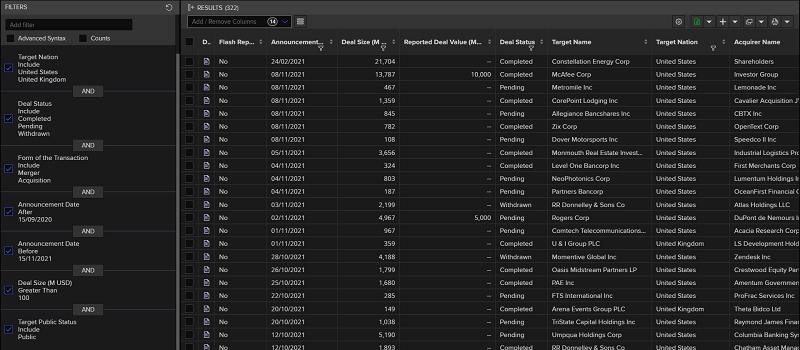

After clicking on the Excel icon on the top right of the interface, an excel file containing the requested data will be downloaded.

While this is a great first step of getting data on M&A using Refinitiv, it is perhaps not the most scaleable approach of data retrieval for AI pipelines. We would want to access the data programmatically and integrate it in the pipeline. One of the underlying reasons is that we want to be able to automaticaly replay the pipeline at any given time. This is perfectly possible by accessing data through Refinitiv APIs, particularly, RDP Search API. To do that, we need to install/import the required libraries and authorise ourselves using APP KEY GENERATOR. 

In [ ]:
!pip install refinitiv.dataplatform

In [2]:
import refinitiv.dataplatform as rdp
import pandas as pd
import datetime
import time
import os
app_key = ''

rdp.open_desktop_session(app_key)

The code below requests M&A data using the filters shown in the screenshot above and orders the data by the announcement date in descending order. More on how you can use search, including guidance, examples, and tips to determine the possible approaches, from simple discovery through experimentation to more advanced techniques, are presented in this article. **+++**

For the purposes of presenting a Data Ingestion phase workflow, we request data for a short time period (January-April 2022).

In [3]:
#build search query with the specified filters
MnA = rdp.search(
    view = rdp.SearchViews.DealsMergersAndAcquisitions,
    
    #specify filtering properties
    filter = "((AcquirerCompanyName ne 'Creditors' and AcquirerCompanyName ne 'Shareholder') and (TargetCountry eq 'US' or TargetCountry eq 'UK')"
    + "and TransactionValueIncludingNetDebtOfTarget ge 100 and TargetPublicStatus eq 'Public')"
    + "and (TransactionStatus eq 'Completed' or TransactionStatus eq 'Pending' or TransactionStatus eq 'Withdrawn')"
    + "and (FormOfTransactionName xeq 'Merger' or FormOfTransactionName xeq 'Acquisition') and (TransactionAnnouncementDate le 2022-04-14 and TransactionAnnouncementDate ge 2022-01-01)",
    
    #select only the required fields and order them based on announcement date
    #then specify number of items to be 10000, default value is 100
    select = 'TransactionAnnouncementDate, TargetCompanyName, TargetRIC',
    order_by = 'TransactionAnnouncementDate desc',
    top = 10000)

print(f'Number of M&A deals for the specified period is {len(MnA)}')
MnA.head()

Number of M&A deals for the specified period is 74


,TargetRIC,TransactionAnnouncementDate,TargetCompanyName
0,[TWTR.K],2022-04-14T00:00:00.000Z,Twitter Inc
1,[VWTR.O],2022-04-14T00:00:00.000Z,Vidler Water Resources Inc
2,[SRRA.O],2022-04-13T00:00:00.000Z,Sierra Oncology Inc
3,[ATRS.O],2022-04-13T00:00:00.000Z,Antares Pharma Inc
4,[OOUT.L],2022-04-13T00:00:00.000Z,Ocean Outdoor Ltd


Let's also create a list of RICs which will be useful for the next part of data ingestion - financial ratio retrieval.

In [4]:
#create list of RICs
rics = MnA['TargetRIC'].to_list()
rics = [rics[i][0] for i in range(len(rics))]

Having defined the list of target companies, the next step is to request financial ratios for them. We need to consider two different workflows of data retrieval depending on whether we want all ratios as of one universal date or as of a specific day for each company, e.g 30 days before the M&A announcement date. In this case, it would be more appropriate to request data as of a specific date for each company. However, we do present both workflows as the first workflow might be applicable for a diffenet use case that could be encountered. 

<u>Workflow for ingesting data as of a universal date. </u>

In order to get the financial ratios for the list of companies we use **RDP get_data** function. We specify the ratios under the field argument and the date in the parameters. Since the request is as of a date for all companies in our list, the request workflow doesn't require loop procedures and multiple API requests. This allows us to receive the data relatively faster. We time the request to compare with the workflow involving looping and multiple API requests.

In [5]:
start_time = time.time()

#specify variables
fields = ["TR.TRBCIndustry", "TR.F.MktCap","TR.F.TotRevenue", "TR.F.ReturnAvgTotEqPctTTM", "TR.F.IncAftTaxMargPctTTM", "TR.F.GrossProfMarg", "TR.F.OpMargPctTTM","TR.F.CurrRatio",
           "TR.F.ReturnCapEmployedPctTTM","TR.F.WkgCaptoTotAssets","TR.PriceToBVPerShare","TR.PriceToSalesPerShare","TR.EVToSales",
           "TR.F.NetDebttoTotCap","TR.TotalDebtToEV","TR.F.NetDebtPerShr"]

#get data for fields as of the specified date 
df = rdp.get_data(rics, fields = fields , parameters = {'SDate': '2021-12-12'})
#add anoouncement date to the resulting dataframe
print("--- %s seconds ---" % (time.time() - start_time))

df

--- 6.542376756668091 seconds ---


,instrument,TR.TRBCIndustry,TR.F.MktCap,TR.F.TotRevenue,TR.F.ReturnAvgTotEqPctTTM,TR.F.IncAftTaxMargPctTTM,TR.F.GrossProfMarg,TR.F.OpMargPctTTM,TR.F.CurrRatio,TR.F.ReturnCapEmployedPctTTM,TR.F.WkgCaptoTotAssets,TR.PriceToBVPerShare,TR.PriceToSalesPerShare,TR.EVToSales,TR.F.NetDebttoTotCap,TR.TotalDebtToEV,TR.F.NetDebtPerShr
0,TWTR.K,Online Services,43068180352.650002,3716349000.0,-2.415621,-3.77111,63.23305,7.449228,4.42288,3.026157,0.49961,5.079074,7.590733,6.932172,-0.34781,12.776466,-5.006278
1,VWTR.O,Water & Related Utilities,173754472.1,9612000.0,5.406925,100.952175,76.96629,-0.032461,35.56061,-0.001739,0.05056,1.321955,25.035564,35.459065,-0.05266,0.0,-0.505193
2,SRRA.O,Biotechnology & Medical Research,178389598.52,300000.0,-87.033535,-43607.5,100.0,-43453.5,11.38351,-86.398545,0.90352,3.431903,1693.692,1208.352,-1.06223,0.0,-9.35033
3,ATRS.O,"Medical Equipment, Supplies & Distribution",665022991.71,149599000.0,63.077901,36.230454,57.82057,14.628313,2.00286,19.493732,0.29824,3.900046,3.061779,2.860837,-0.07648,4.154202,-0.073353
4,OOUT.L,Advertising & Marketing,274917447.04326,86171000.0,-55.637164,-158.168059,26.04937,-29.034724,0.65895,-5.741246,-0.0677,2.236183,4.37059,6.352996,0.40515,35.827869,3.195892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,ZNGA.O^E22,Online Services,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2.283089,2.568871,2.565343,<NA>,19.056399,<NA>
70,APR.O^C22,"Medical Equipment, Supplies & Distribution",<NA>,1108717000.0,82.284663,6.459036,70.3919,10.84777,1.08674,29.922851,0.03404,47.688877,0.967404,1.112603,0.54472,30.081368,5.737567
71,VCRA.K^B22,Communications & Networking,1349450528.23,198420000.0,-4.763463,-3.429763,64.82058,-0.59022,3.68035,-0.379209,0.53438,12.986571,8.797953,8.59942,-0.34198,13.432629,-3.205408
72,SAA.L,Advertising & Marketing,96499998.32,323250000.0,-4.737815,-0.807456,65.41531,2.746858,0.94794,9.192672,-0.03397,3.452427,0.52954,0.568548,0.09944,44.234856,0.116156


<u>Workflow for requesting data as of different dates. </u>

Again, we use the **RDP get_data** function, however, we call it under a loop by updating the date parameter. Since the process involves multiple API requests, it is advised to use a try - except statement to catch and respond to potential errors.

For our use case we want our feature space to be representative to the company fundamentals landscape 30 days prior to the M&A announcement. The snippet below creates a dataframe of deals containing dates materialised 30 days prior to the Announcement date.

In [6]:
#create list of announcement dates including one for 30 days prior to the announcement
deals = pd.DataFrame(MnA['TransactionAnnouncementDate'])
deals.insert(loc = len(deals.columns), column = 'AD-30', value = (pd.to_datetime(deals['TransactionAnnouncementDate']) - datetime.timedelta(30)).dt.strftime('%Y-%m-%d'))
deals.insert(loc = len(deals.columns), column = 'rics', value = rics)

The code below calls get_data function for each RIC in the loop and concatenates the per RIC results to re-create the target dataset. We catch RICs throwing an exception, mainly due to connection issues to re-run the API request. Again, we time the request for reference purposes.

In [7]:
start_time = time.time()

#create list of request dates
dates_30 = deals['AD-30'].to_list()

#create empty lists and dataframe to store requested values
target_data = pd.DataFrame()
error_target = []
error_target_dates = []

for i in range(len(rics)):
    try:
        #get data for fields as of the specified date 
        df = rdp.get_data(rics[i], fields = fields , parameters = {'SDate': dates_30[i]})
        #add anoouncement date to the resulting dataframe
        df.insert(loc = 1, column = 'AD-30', value = dates_30[i])
        #append company data to the main dataframe
        target_data = pd.concat([target_data, df], ignore_index = True, axis = 0)
    #if error is returned, store ric and request date into a separate list
    except:
        error_target.append(rics[i])
        error_target_dates.append(dates_30[i])
        continue
        
print ("--- %s seconds ---" % (time.time() - start_time))

--- 35.40153622627258 seconds ---


Let's loop over the RICs exception list and re-trigger the API call. This will allow us to retrieve feature values for any RICs throwing exceptions due to connectivity issues.

In [8]:
#run the data request code above for the companies in the error list
for i in range(len(error_target)):
    df =rdp.get_data(error_target[i], fields = fields , parameters = {'SDate': error_target_dates[i]})
    df.insert(loc = 1, column = 'AD-30', value = error_target_dates[i])
    target_data = pd.concat([target_data, df], ignore_index = True, axis = 0)

In [9]:
target_data

,instrument,AD-30,TR.TRBCIndustry,TR.F.MktCap,TR.F.TotRevenue,TR.F.ReturnAvgTotEqPctTTM,TR.F.IncAftTaxMargPctTTM,TR.F.GrossProfMarg,TR.F.OpMargPctTTM,TR.F.CurrRatio,TR.F.ReturnCapEmployedPctTTM,TR.F.WkgCaptoTotAssets,TR.PriceToBVPerShare,TR.PriceToSalesPerShare,TR.EVToSales,TR.F.NetDebttoTotCap,TR.TotalDebtToEV,TR.F.NetDebtPerShr
0,TWTR.K,2022-03-15,Online Services,34559138538.18,5077482000,-2.89853934086831,-4.36060630052455,64.5984,5.37593240113899,5.89223,2.26131210066079,0.46762,3.716208424,5.356548858,4.93494953,-0.18517,16.97329717,-2.67789072585891
1,VWTR.O,2022-03-15,Water & Related Utilities,173754472.1,9612000,5.40692468843538,100.952174853928,76.96629,-0.0324605063839,35.56061,-0.001738560993066,0.05056,1.236127045,23.410135457,22.69751914,-0.05266,0,-0.505192918258623
2,SRRA.O,2022-03-14,Biotechnology & Medical Research,327296569.6,0,-97.608233,None,None,None,8.33538,-97.201169,0.86415,5.116046,3574.613355,3089.273355,-1.09116,0,-6.726902
3,ATRS.O,2022-03-14,"Medical Equipment, Supplies & Distribution",607051650.03,183982000,31.3958890776707,25.1595264754161,62.88713,14.8612364253025,2.95727,15.7182646787448,0.44792,3.686741542,3.522655359,3.26492906,-0.24254,3.286397288,-0.278805447104756
4,OOUT.L,2022-03-14,Advertising & Marketing,274917447.04326,86171000,-55.6371638198894,-158.168059033395,26.04937,-29.0347242227491,0.65895,-5.74124626999741,-0.0677,2.1996582159822,4.2746928953409,6.25709810729826,0.40515,36.3769729449981,3.19589248742975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,ZNGA.O^E22,2021-12-11,Online Services,None,None,None,None,None,None,None,None,None,2.283089,2.568871,2.565343,None,19.056399,None
70,APR.O^C22,2021-12-11,"Medical Equipment, Supplies & Distribution",None,1108717000,82.284663,6.459036,70.3919,10.84777,1.08674,29.922851,0.03404,47.688877,0.967404,1.112603,0.54472,30.081368,5.737567
71,VCRA.K^B22,2021-12-07,Communications & Networking,1349450528.23,198420000,-4.76346263055233,-3.42976253438874,64.82058,-0.590219599024004,3.68035,-0.379209171836295,0.53438,13.171474262,8.923217899,8.724685448,-0.34198,13.239769001,-3.20540810492026
72,SAA.L,2021-12-07,Advertising & Marketing,96499998.32,323250000,-4.73781549173194,-0.807456295377769,65.41531,2.74685796070206,0.94794,9.19267184750307,-0.03397,3.556345815,0.545479161,0.584487383,0.09944,43.028544927,0.11615635435381


<u>Optimising ingestion requests</u>

One important concern during data ingestion is making sure that we have an optimised ingestion layer that is not presenting any unecessary bottlenecks within our pipeline. This is a proprietary decision and in this case, we did notice that there are dates for which multiple M&A has been announced. To optimise our ingestion request we could bundle the deals by date. That will allow us to reduce API calls and retrieve the results much faster.

The code below groups our dataframe by the AD-30 and makes an API call for each date requesting feature values for the list of rics instead of making individual call for each ric.  

In [10]:
start_time = time.time()

dfs = dict(tuple(deals.groupby('AD-30', sort = False)))

#create empty lists and dataframe to store requested values
target_data = pd.DataFrame()
error_target = []
error_target_dates = []

for date in dfs:
    rics = []
    for ric in dfs[date]['rics']:
        rics.append(ric)
        #get data for fields as of the specified date
    try:
        df = rdp.get_data(rics, fields = fields , parameters = {'SDate': date})
        #add anoouncement date to the resulting dataframe
        df.insert(loc = 1, column = 'AD-30', value = date)
        #append company data to the main dataframe
        target_data = pd.concat([target_data, df], ignore_index = True, axis = 0)
        #if error is returned, store ric and request date into a separate list
    except:
        error_target.append(rics)
        error_target_dates.append(date)
        continue

print ("--- %s seconds ---" % (time.time() - start_time))

--- 40.13558840751648 seconds ---


In [11]:
#run the data request code above for the companies in the error list
for i in range(len(error_target)):
    df =rdp.get_data(error_target[i], fields = fields , parameters = {'SDate': error_target_dates[i]})
    df.insert(loc = 1, column = 'AD-30', value = pd.to_datetime(deals['TransactionAnnouncementDate'][i]))
    target_data = pd.concat([target_data, df], ignore_index = True, axis = 0)

In [12]:
target_data.head()

,instrument,AD-30,TR.TRBCIndustry,TR.F.MktCap,TR.F.TotRevenue,TR.F.ReturnAvgTotEqPctTTM,TR.F.IncAftTaxMargPctTTM,TR.F.GrossProfMarg,TR.F.OpMargPctTTM,TR.F.CurrRatio,TR.F.ReturnCapEmployedPctTTM,TR.F.WkgCaptoTotAssets,TR.PriceToBVPerShare,TR.PriceToSalesPerShare,TR.EVToSales,TR.F.NetDebttoTotCap,TR.TotalDebtToEV,TR.F.NetDebtPerShr
0,TWTR.K,2022-03-15,Online Services,34559138538.18,5077482000,-2.89853934086831,-4.36060630052455,64.5984,5.37593240113899,5.89223,2.26131210066079,0.46762,3.716208424,5.356548858,4.93494953,-0.18517,16.97329717,-2.67789072585891
1,VWTR.O,2022-03-15,Water & Related Utilities,173754472.1,9612000,5.40692468843538,100.952174853928,76.96629,-0.0324605063839,35.56061,-0.001738560993066,0.05056,1.236127045,23.410135457,22.69751914,-0.05266,0,-0.505192918258623
2,SRRA.O,2022-03-14,Biotechnology & Medical Research,327296569.6,0,-97.608233,<NA>,<NA>,<NA>,8.33538,-97.201169,0.86415,5.116046,3574.613355,3089.273355,-1.09116,0.0,-6.726902
3,ATRS.O,2022-03-14,"Medical Equipment, Supplies & Distribution",607051650.03,183982000,31.395889,25.159526,62.88713,14.861236,2.95727,15.718265,0.44792,3.686742,3.522655,3.264929,-0.24254,3.286397,-0.278805
4,OOUT.L,2022-03-14,Advertising & Marketing,274917447.04326,86171000,-55.637164,-158.168059,26.04937,-29.034724,0.65895,-5.741246,-0.0677,2.199658,4.274693,6.257098,0.40515,36.376973,3.195892


As we see the optimized version of our code returned the data roughly 40% faster due to the decreaseing the number of API calls. Considering that there is a daily API call limit and for large requests you may hit that, this approach should always be the go to strategy for API calls. Furthermore, this is a significant result that can greatly affect our time to data retrieval, in a productionised AI pipeline.

#### Data Ingestion for non-target dataset

The non-target sample set is constructed from companies similar to target companies in terms of business activity. To identify the non-target control group, this would be a complicated identification process, however, Refinitiv has a great function called **Peer Screener** which allows us to easily retrieve the top 50 peers of the any company.

The below code stores the RICs and dates into separate lists and calls the Peer Screener function for each RIC The resulting dataframe is then merged with the main dataframe of peer companies. We present a try/except statement to catch API request errors and allow the code to gracefuly handle the exception This is also an important part of any AI pipeline, as there will appear events during which our existing code might fail to handle, we should always provide for failover or pass through scenarios. Furthermore, such events should be logged so that AI engineers can revisit the pipeline and introduce new functionality to handle those.

In [13]:
#store rics and dates into separate lists
target_rics = target_data['instrument'].to_list()
target_dates = target_data['AD-30'].to_list()

#create empty lists for error data and a dataframe to store selected peers
no_peers = []
no_dates = []
peer_data = pd.DataFrame()

for i in range(len(target_rics)):
    try:
        #request Peer function for each target company in the lits
        instruments = 'SCREEN(U(IN(Peers("{}"))))'.format(target_rics[i])
        vals = rdp.get_data(instruments, fields = fields, parameters = {'SDate': target_dates[i]})
        
        #add a column for 30 days prior to the M&A announcement
        vals.insert(loc = 1, column = 'AD-30', value = target_dates[i])
        
        #append target company's peer data to the main dataframe of all peers
        peer_data = pd.concat([peer_data, vals], ignore_index = True, axis = 0)
        
    #if error is returned, store ric and request date in a separate list    
    except:
        no_peers.append(target_rics[i])
        no_dates.append(target_dates[i])
        continue

In [14]:
#run the data request code above for the companies in the error list
for i in range(len(no_peers)):
    try:
        instruments = 'SCREEN(U(IN(Peers("{}"))))'.format(no_peers[i])
        vals = rdp.get_data(instruments, fields = fields, parameters = {'SDate': no_dates[i]})
        vals.dropna(inplace = True)
        peer_data = pd.concat([peer_data, vals], ignore_index = True, axis = 0)
    except:
        continue

In [16]:
peer_data

,instrument,AD-30,TR.TRBCIndustry,TR.F.MktCap,TR.F.TotRevenue,TR.F.ReturnAvgTotEqPctTTM,TR.F.IncAftTaxMargPctTTM,TR.F.GrossProfMarg,TR.F.OpMargPctTTM,TR.F.CurrRatio,TR.F.ReturnCapEmployedPctTTM,TR.F.WkgCaptoTotAssets,TR.PriceToBVPerShare,TR.PriceToSalesPerShare,TR.EVToSales,TR.F.NetDebttoTotCap,TR.TotalDebtToEV,TR.F.NetDebtPerShr
0,FB.OQ,2022-03-15,Online Services,935644813206.599976,117929000000.0,31.101754,33.384494,80.79438,39.645041,3.15429,32.334095,0.2743,4.214914,4.432281,4.0302,-0.37795,0.122244,-17.299161
1,SNAP.N,2022-03-15,Software,75708776707.179993,4117048000.0,-15.945867,-11.85206,57.48784,-17.052728,5.69862,-12.716993,0.53106,12.637538,11.670182,11.320466,-0.23825,4.834235,-0.889158
2,GOOGL.OQ,2022-03-15,Online Services,1921854645843.659912,257637000000.0,32.069324,29.511677,56.9398,30.552289,2.92811,28.223221,0.34484,6.799111,6.629185,6.15643,-0.46787,0.941288,-188.362852
3,MSFT.OQ,2022-03-15,Software,2040303545865.899902,168088000000.0,49.051494,38.498564,68.9258,42.523918,2.07999,31.480792,0.28686,13.459315,11.642457,11.329233,-0.28046,3.220007,-7.932837
4,035720.KS,2022-03-15,Online Services,50150798662500.0,6136669167665.0,15.664447,26.824867,94.65156,9.660415,1.45577,4.529939,0.11265,5.081244,8.22591,7.943871,-0.24853,5.408369,-9682.883299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,TEAM.OQ,NaN,Software,64707506960.040001,2089132000,-362.616433,-21.836568,83.99761,1.742295,0.70454,4.286427,-0.23172,611.177339,31.082882,31.222763,-0.69047,1.747173,-2.470157
3364,ZM.OQ,NaN,Software,108306837820.660004,2651368000,34.643991,29.292148,68.99755,27.304944,3.80396,30.846219,0.66684,7.397029,9.710315,8.365789,-1.09945,0.0,-14.45997
3365,VMW.N,NaN,IT Services & Consulting,57866393164.5,11767000000,21.656596,16.053591,82.63789,20.667512,1.02695,11.434461,0.00779,5.034725,4.07287,3.928982,0.0232,21.626234,0.779864
3366,AYX.N,NaN,Software,4080958167.0,536135000,-40.857716,-33.514134,89.60094,-25.416173,2.28129,-11.413167,0.32755,9.081577,6.83261,7.026903,0.08932,20.263905,1.542438


#### Conclusion

In this guide, we presented the business incentive for an M&A AI model and discussed data ingestion approaches to acquire the dataset for our pipeline. Furthermore, in the next phase of Data Engineering, the Data Exploration phase, we will explore more about the specifics of our dataset and the available feature space.